## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import tensorflow as tf
# 本範例不需使用 GPU, 將 GPU 設定為 "無"
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# 自動增長 GPU 記憶體用量
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.75) #占用75%顯存
sess =  tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    # 資料前處理 - 標準化
    x = x / 255.
    if flatten:
        # 將資料從圖形 (RGB) 轉為向量 (Single Vector)
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        # 用np_utils裡的to_categorical來做one-hot encoding的轉換：
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
            x = keras.layers.Dropout(0.25)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    #定義一個具有輸入和輸出的模型
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3  #學習率
EPOCHS = 50 #訓練50週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = 256 #訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
MOMENTUM = 0.95 #動量
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, #訓練資料
              epochs=EPOCHS,   #訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
              batch_size=BATCH_SIZE,  #訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
              validation_data=(x_test, y_test), #驗證資料
              shuffle=True)    #每次epochs後，將訓練集打亂順序
    
    # Collect results
    #history.history:記錄了損失函數和其他指標的數值隨epoch變化的情況，如果有驗證集的話，也包含了驗證集的這些指標變化情況
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)        

50000/50000 [==============================] - 3s 54us/step - loss: 3.0430 - accuracy: 0.5516 - val_loss: 3.0993 - val_accuracy: 0.5264
Epoch 44/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.9925 - accuracy: 0.5517 - val_loss: 3.0587 - val_accuracy: 0.5263
Epoch 45/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.9527 - accuracy: 0.5565 - val_loss: 3.0090 - val_accuracy: 0.5265
Epoch 46/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.9168 - accuracy: 0.5569 - val_loss: 2.9867 - val_accuracy: 0.5213
Epoch 47/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.8771 - accuracy: 0.5558 - val_loss: 2.9692 - val_accuracy: 0.5100
Epoch 48/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.8355 - accuracy: 0.5616 - val_loss: 2.9055 - val_accuracy: 0.5301
Epoch 49/50
50000/50000 [==============================] - 3s 52us/step - loss: 2.7960 - accuracy: 0.5623 - val_loss: 2.8755

50000/50000 [==============================] - 3s 52us/step - loss: 1.2807 - accuracy: 0.5455 - val_loss: 1.3343 - val_accuracy: 0.5240
Epoch 36/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2695 - accuracy: 0.5436 - val_loss: 1.3371 - val_accuracy: 0.5230
Epoch 37/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.2580 - accuracy: 0.5538 - val_loss: 1.3367 - val_accuracy: 0.5244
Epoch 38/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.2497 - accuracy: 0.5539 - val_loss: 1.3234 - val_accuracy: 0.5298
Epoch 39/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.2405 - accuracy: 0.5559 - val_loss: 1.3180 - val_accuracy: 0.5283
Epoch 40/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.2319 - accuracy: 0.5606 - val_loss: 1.3567 - val_accuracy: 0.5180
Epoch 41/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.2232 - accuracy: 0.5653 - val_loss: 1.3103

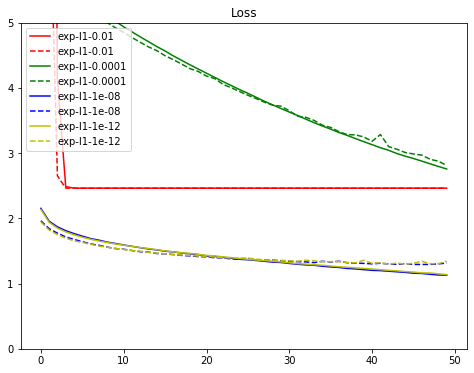

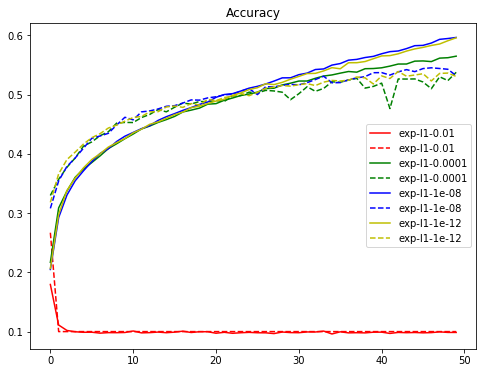

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    #定義一個具有輸入和輸出的模型
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3  #學習率
EPOCHS = 50 #訓練50週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = 256 #訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
MOMENTUM = 0.95 #動量
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [ ]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
import itertools
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, #訓練資料
              epochs=EPOCHS,   #訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
              batch_size=BATCH_SIZE,  #訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
              validation_data=(x_test, y_test), #驗證資料
              shuffle=True) #每次epochs後，將訓練集打亂順序
    
    # Collect results
    #history.history:記錄了損失函數和其他指標的數值隨epoch變化的情況，如果有驗證集的話，也包含了驗證集的這些指標變化情況
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}


Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/500

Epoch 49/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.4614 - accuracy: 0.0980 - val_loss: 2.4612 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.4614 - accuracy: 0.0976 - val_loss: 2.4613 - val_accuracy: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
________________________________________________

Epoch 47/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.4626 - accuracy: 0.0975 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.4626 - accuracy: 0.0965 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.4626 - accuracy: 0.0984 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.4626 - accuracy: 0.0982 - val_loss: 2.4626 - val_accuracy: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
________________

Epoch 45/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.4626 - accuracy: 0.0987 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.4626 - accuracy: 0.0976 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.4626 - accuracy: 0.0974 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 3s 50us/step - loss: 2.4626 - accuracy: 0.0991 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 3s 50us/step - loss: 2.4626 - accuracy: 0.0973 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 3s 50us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4626 - val_accuracy: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000000
Model: "model_1"
__________________________________________________

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()